In [1]:

from monai.transforms import (Compose)
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
#from UNet_model import create_unet
import numpy as np
from monai.transforms import Compose, Invertd, SaveImaged
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
import torch
import json


In [59]:
config_file = 'config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
output_dir = config["output_dir"]


In [3]:
# from data_preparation import ExtrenalRadioSetSetHandling

# data_handler = ExtrenalRadioSetSetHandling(fdg_data_dir, train_mode="NAC", target_mode="MAC")

# test_files = data_handler.get_data()
# len(test_files)
# from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd, RandSpatialCropSamplesd, CenterSpatialCropd
# from monai.data import CacheDataset, DataLoader, Dataset


# spacing = (4.07, 4.07, 3.00)
# spatial_size = (168, 168, 640)

# test_transforms = Compose([
#         LoadImaged(keys=["image", "target"]),
#         EnsureChannelFirstd(keys=["image", "target"]),
#         Spacingd(keys=["image", "target"], pixdim=spacing, mode= 'trilinear'),
#         SpatialPadd(keys=["image", "target"], spatial_size=spatial_size, mode='constant'),  # Ensure minimum size
#         CenterSpatialCropd(keys=["image", "target"], roi_size=spatial_size),  # Ensure uniform size
#     ])

# test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=1)
# test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=1)

In [62]:
from data_preparation import DataHandling 

data_handler = DataHandling(ga_data_dir, train_mode="NAC", target_mode="MAC")

train_files = data_handler.get_data_split('train')
val_files = data_handler.get_data_split('val')
test_files = data_handler.get_data_split('test')
print(len(train_files))
print(len(val_files))
print(len(test_files))

from data_preparation import LoaderFactory
loader_factory = LoaderFactory(
    train_files=train_files,
    val_files=val_files,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    # spacing = [1.92, 1.92, 3.27],
    spatial_size = (168, 168, 320)
    # spatial_size = (168, 168, 640)
    # spatial_size = (336, 336, 640)
    )

# Get the DataLoader for each dataset type
# train_loader = loader_factory.get_loader('train', batch_size=4, num_workers=2, shuffle=True)
# val_loader = loader_factory.get_loader('val', batch_size=1, num_workers=2, shuffle=False)
test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)



131
33
20


In [ ]:
# from monai.transforms import LoadImage

# # Assuming 'test_files' contains your image paths like {'image': 'path/to/image.nii', 'target': 'path/to/target.nii'}
# loader = LoadImage(image_only=True)

# for i in test_files:
#     image_path = i['image']  # Replace 'test_files[0]['image']' with the actual path if necessary
#     original_image = loader(image_path)
#     print(f"Original image size: {original_image.shape}")

# print('--------------------------')
# for batch in test_loader:
#     transformed_image = batch['image']
#     print(f"Transformed image size: {transformed_image.shape}")
#       # Break after the first batch since you're only interested in one image


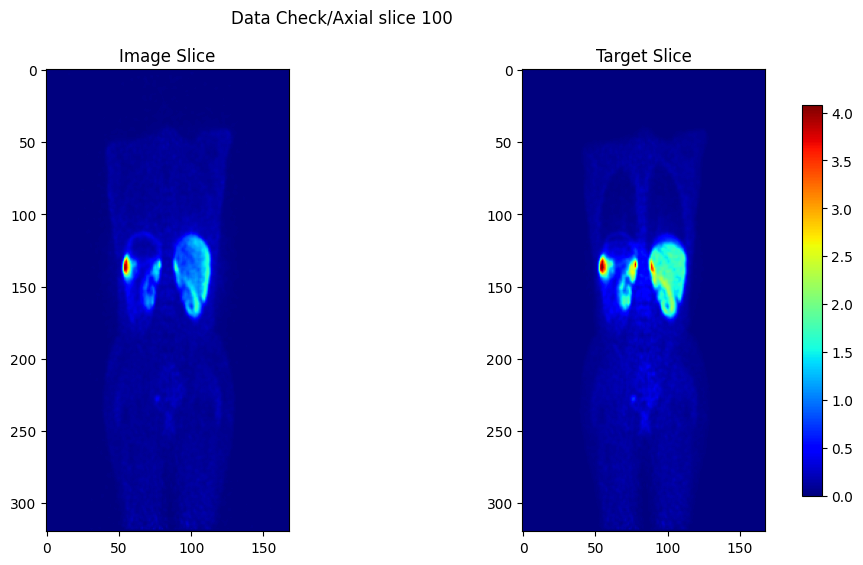

In [63]:
from data_preparation import visualize_axial_slice, visualize_axial_slice2


slice_index = 100  # Example slice index.
# visualize_axial_slice(test_loader, slice_index)
visualize_axial_slice2(test_loader, slice_index)


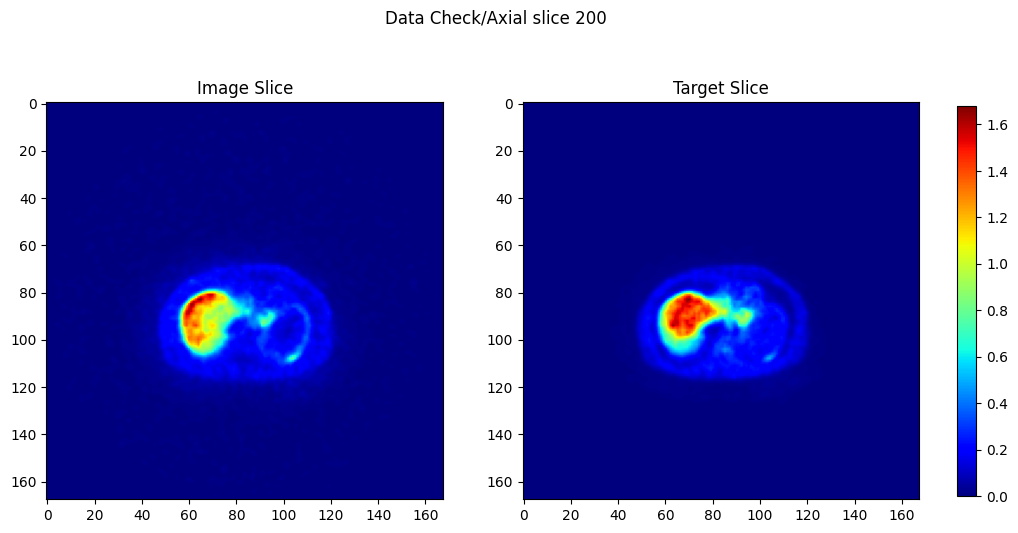

In [64]:
from data_preparation import visualize_axial_slice, visualize_axial_slice2


slice_index = 200  # Example slice index.
visualize_axial_slice(test_loader, slice_index)



In [65]:
from utils import find_last_saved_model, parse_loss_values

# log_filename = 'log_2_26_8_17.txt'
# log_filename = 'log_3_4_12_4.txt'
# log_filename = 'log_3_4_12_41.txt'
# log_filename = 'log_3_18.txt'
log_filename = 'log_3_27_8_47.txt'

log_filepath = log_dir + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_3_27_12_42.pth, Best Metric: 0.0012, Epoch: 20


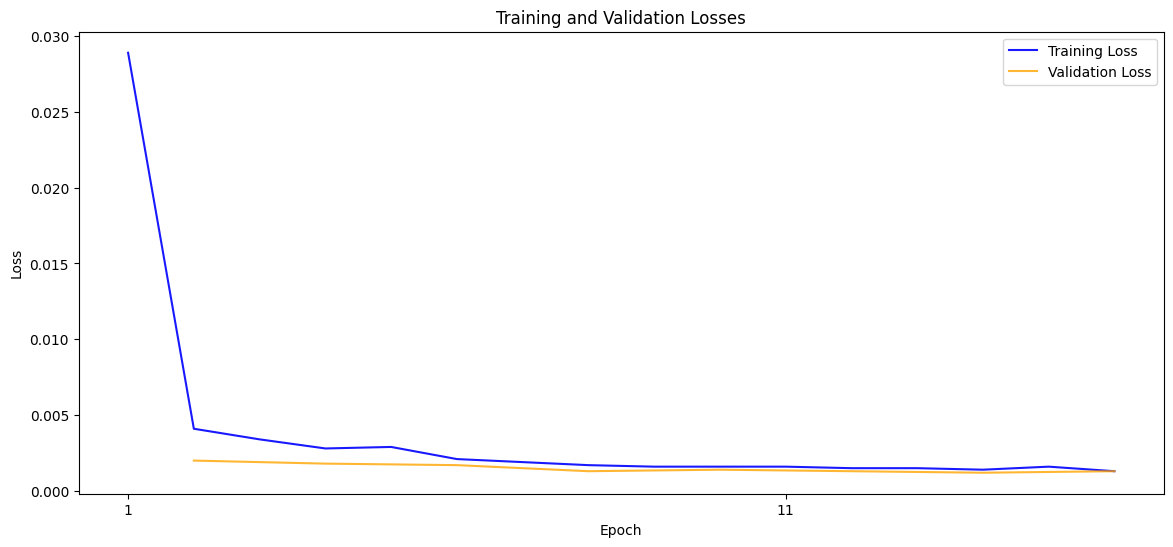

In [13]:
train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 10))  # Adjust the x-axis ticks if needed
plt.show()


In [14]:
import os
import torch
from model_maker import get_network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_network(patch_size = [168, 168, 16], spacing = [4.07, 4.07, 3.00])
model = model.to(device)


DyUnet is set:
Kernel size:  [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides:  [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 1]]


In [27]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(log_dir, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")

Model file model_3_27_12_42.pth is loading.


In [66]:
# Extract file names
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]
test_name


[('007026_C5_RJ_.nii', '007026_C5_RJ_.nii'),
 ('007035_C5_RJ_.nii', '007035_C5_RJ_.nii'),
 ('007037_C5_RJ_.nii', '007037_C5_RJ_.nii'),
 ('007038_C5_RJ_.nii', '007038_C5_RJ_.nii'),
 ('007042_C5_RJ_.nii', '007042_C5_RJ_.nii'),
 ('007043_C5_RJ_.nii', '007043_C5_RJ_.nii'),
 ('007046_C5_RJ_.nii', '007046_C5_RJ_.nii'),
 ('007051_C5_RJ_.nii', '007051_C5_RJ_.nii'),
 ('007057_C5_RJ_.nii', '007057_C5_RJ_.nii'),
 ('007058_C5_RJ_.nii', '007058_C5_RJ_.nii'),
 ('007066_C5_RJ_.nii', '007066_C5_RJ_.nii'),
 ('007067_C5_RJ_.nii', '007067_C5_RJ_.nii'),
 ('001595_C1_RZ_.nii', '001595_C1_RZ_.nii'),
 ('001216_C1_RZ_.nii', '001216_C1_RZ_.nii'),
 ('002301_C2_IM_.nii', '002301_C2_IM_.nii'),
 ('002401_C2_IM_.nii', '002401_C2_IM_.nii'),
 ('003232_C3_KH_.nii', '003232_C3_KH_.nii'),
 ('003221_C3_KH_.nii', '003221_C3_KH_.nii'),
 ('004136_C4_SH_.nii', '004136_C4_SH_.nii'),
 ('004123_C4_SH_.nii', '004123_C4_SH_.nii')]

100%|██████████| 3/3 [00:49<00:00, 16.58s/it]


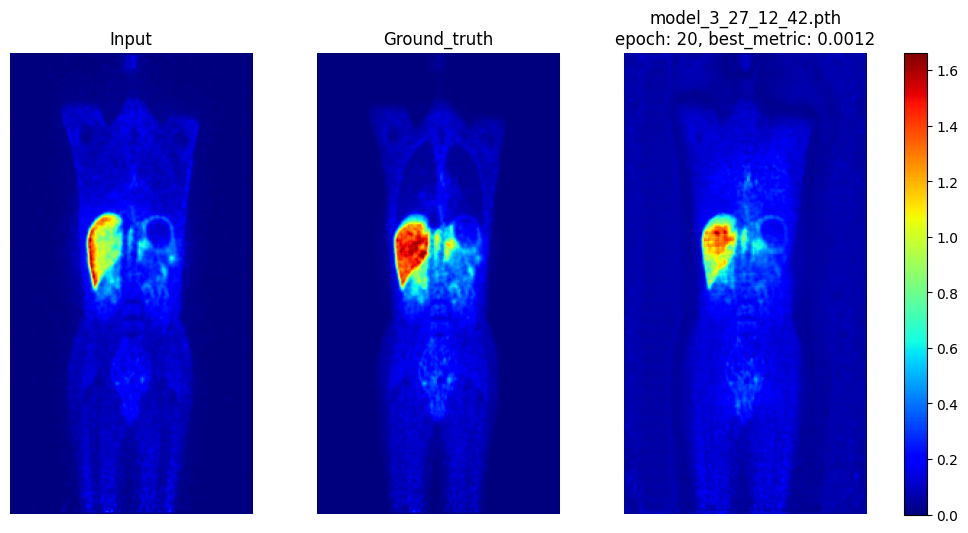

In [68]:
import torch
from data_preparation import visualize_coronal_slice

roi_size = (160, 160, 32)
sw_batch_size = 64
slice_number = 95

with torch.no_grad():
    for i, data in enumerate(test_loader):

        predict = sliding_window_inference(data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70)
        
        visualize_coronal_slice(data, predict, slice_number, f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}", Norm=False)
        if i == 0:
            break


In [69]:

from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd, RandSpatialCropSamplesd, CenterSpatialCropd
from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import Transform

from monai.transforms import MapTransform

class ClampNegative(MapTransform):
    """
    A MONAI transform that sets negative pixel values to zero within a dictionary format.
    This is useful for ensuring that the output predictions do not have negative values.
    Operates on all specified keys.
    """
    def __init__(self, keys):
        super().__init__(keys)
    
    def __call__(self, data):
        for key in self.keys:
            d = data[key]
            d[d < 0] = 0
            data[key] = d
        return data

    

roi_size = (160, 160, 32)
sw_batch_size = 64


post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=loader_factory.get_test_transforms(),
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        ClampNegative(keys=["pred"]),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=output_dir, output_postfix="comb_3_27_11_26_onga", resample=False), 
    ]
)


with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.70)
        post_processed = [post_transforms(i) for i in decollate_batch(test_data)]



2024-03-27 21:15:35,033 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/OUTPUT/007026_C5_RJ_/007026_C5_RJ__comb_3_27_11_26_onga.nii.gz
2024-03-27 21:16:19,211 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/OUTPUT/007035_C5_RJ_/007035_C5_RJ__comb_3_27_11_26_onga.nii.gz
2024-03-27 21:17:02,841 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/OUTPUT/007037_C5_RJ_/007037_C5_RJ__comb_3_27_11_26_onga.nii.gz
2024-03-27 21:17:46,924 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/OUTPUT/007038_C5_RJ_/007038_C5_RJ__comb_3_27_11_26_onga.nii.gz
2024-03-27 21:18:23,879 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/OUTPUT/007042_C5_RJ_/007042_C5_RJ__comb_3_27_11_26_onga.nii.gz
2024-03-27 21:19:03,649 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/OUTPUT/007043_C5_RJ_/007043_C5_RJ__comb_3_27_11_26_onga.nii.gz
2024-03-27 21:19:49,816 INFO image_write

In [11]:
# import os
# import glob
# from utils import PairFinder
# hint = 'dl_dyn2'
# hint = 'gamodel_3_18_onfdg'
# hint = 'Areset_test'

# pair_finder = PairFinder(f'{fdg_data_dir}/MAC', output_dir, hint)
# test_dict_list = pair_finder.find_file_pairs()
# test_dict_list

[{'predicted': '/students/2023-2024/master/Shahpouri/OUTPUT/005001_dataset_06_Areset/005001_dataset_06_Areset_test.nii.gz',
  'reference': '/students/2023-2024/master/Shahpouri/DATA/FDG_TEST/MAC/005001_dataset_06_Areset.nii.gz'}]

In [ ]:
# import nibabel as nib
# import os

# for item in test_dict_list:
#     predicted_image_path = item['predicted']
#     reference_image_path = item['reference']
    
#     # Handle the '.nii.gz' extension properly
#     if predicted_image_path.endswith('.nii.gz'):
#         base_path = predicted_image_path[:-7]  # Remove '.nii.gz' from the end
#         corrected_dl_image_path = f"{base_path}_corr.nii.gz"
#     else:
#         # For other extensions, split and append '_corrected' before the extension
#         base_path, ext = os.path.splitext(predicted_image_path)
#         corrected_dl_image_path = f"{base_path}_corr{ext}"
    
#     # Load the reference (original) image to get its affine and header
#     orig = nib.load(reference_image_path)
    
#     # Load the DL predicted image
#     dl = nib.load(predicted_image_path)
#     dl_data = dl.get_fdata()
    
#     # Create a new NIfTI image using the DL data but with the original affine and header
#     corrected_dl_img = nib.Nifti1Image(dl_data, orig.affine, header=orig.header.copy())
    
#     # Save the corrected DL image
#     nib.save(corrected_dl_img, corrected_dl_image_path)
 
#     print(f"Corrected image saved to: {corrected_dl_image_path}")


In [ ]:
# # Second method:
# import numpy as np
# import nibabel as nib
# import os

# def write_nifti(data, file_name, affine, output_dtype=np.float32):
#     """
#     Writes the given NIfTI data to a file.

#     Parameters:
#     - data: The image data to write.
#     - file_name: The path to the file where the data should be saved.
#     - affine: The affine matrix for the NIfTI image.
#     - output_dtype: The desired data type for the saved image.
#     """
#     img = nib.Nifti1Image(data.astype(output_dtype), affine)
#     img.to_filename(file_name)

# # Assuming test_dict_list is defined as shown in your example
# for item in test_dict_list:
#     predicted_image_path = item['predicted']
#     reference_image_path = item['reference']
    
#     if predicted_image_path.endswith('.nii.gz'):
#         base_path = predicted_image_path[:-7]  # Correctly handles '.nii.gz' extension
#         corrected_dl_image_path = f"{base_path}_corr2.nii.gz"
#     else:
#         base_path, ext = os.path.splitext(predicted_image_path)
#         corrected_dl_image_path = f"{base_path}_corr2{ext}"
    
#     orig = nib.load(reference_image_path)
#     dl = nib.load(predicted_image_path)
#     dl_data = np.asanyarray(dl.dataobj)  # Directly accessing data
    
#     # Using write_nifti to save the corrected DL image
#     write_nifti(dl_data, corrected_dl_image_path, orig.affine, np.float32)
    
#     print(f"Corrected image saved to: {corrected_dl_image_path}")


In [ ]:
# import nibabel as nib
# import numpy as np

# original_image_path = '/students/2023-2024/master/Shahpouri/DATA/FDG_TEST/MAC/006051_dataset_07_A.nii.gz'
# dl_image_path = '/students/2023-2024/master/Shahpouri/OUTPUT/006051_dataset_07_A/006051_dataset_07_A_test.nii.gz'
# corrected_dl_image_path = '/students/2023-2024/master/Shahpouri/OUTPUT/006051_dataset_07_A/006051_dataset_07_A_corrected.nii.gz'

# # Load the original image to get its affine and header
# orig = nib.load(original_image_path)

# # Load the DL predicted image
# dl = nib.load(dl_image_path)
# # Extract the data from the DL predicted image
# dl_data = dl.get_fdata()

# # Create a new NIfTI image using the DL data but with the original affine and header
# corrected_dl_img = nib.Nifti1Image(dl_data, orig.affine, header=orig.header.copy())

# # Save the DL image with the updated header to the corrected path
# nib.save(corrected_dl_img, corrected_dl_image_path)

# # Load the newly saved corrected DL image
# dl_new = nib.load(corrected_dl_image_path)

# # Print the affine matrix for verification
# print("Affine matrix for original image:", orig.affine)
# print("Affine matrix for dl image:", dl.affine)
# print("Affine matrix for corrected dl image:", dl_new.affine)
